# **Módulo 47 - Series de Tiempo II**

En este módulo profundizaremos en el análisis y modelado de series temporales, aplicando conceptos avanzados para estudiar fenómenos ecónomicos y del mercado de valores. Exploraremos varios modelos de predicción, cada uno con sus características y aplicaciones.

## **Movimiento Geométrico Browniano**

Este modelo se utiliza para predecir precios de acciones, caracterizado por su falta de memoria. Las predicciones futuras dependen únicamente de la volatilidad actual, utilizando un proceso aleatorio para simular posibles trayectorias de precios.

## **Modelos de Reversión a la Media**

Aplicado a la predicción de tasas de interés, este modelo busca que las variables oscilen alrededor de un valor medio a largo plazo. Se exploran parámetros como la velocidad de regresión y el nivel de largo plazo, destacando el modelo Vasicek.

## **Modelos Autoregresivos y Promedios Móviles**

Estos modelos utilizan observaciones de periodos anteriores y errores pasados para predecir valores futuros. se discuten las condiciones y restricciones de los modelos AR y MA, así como su combinación en el modelo ARMA.

___
# **Series de Tiempo II**


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

In [2]:
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import randn, seed
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA

In [3]:
df_apple = pd.read_csv(r'C:\Users\danielortega\OneDrive - HOTELERA YALKUITO SA DE CV\Desktop\No Borrar Daniel\30 Data Analyst - Curso\53_Módulo_47_Series_de_Tiempo_II\Modulo_47_Series_de_Tiempo_II\Analista de datos AAPL_2006-01-01_to_2018-01-01_M30.csv',
                       index_col='Date', parse_dates=True)
df_google = pd.read_csv(r'C:\Users\danielortega\OneDrive - HOTELERA YALKUITO SA DE CV\Desktop\No Borrar Daniel\30 Data Analyst - Curso\53_Módulo_47_Series_de_Tiempo_II\Modulo_47_Series_de_Tiempo_II\Analista de datos GOOGL_2006-01-01_to_2018-01-01_M31.csv',
                        index_col='Date', parse_dates=True)

## **Conceptos Preliminares**

**Autocorrelación**
- La función de autocorrelación (ACF) mide qué tan correlacionada una serie está con ella misma.
- Las unidades de la ACF son los diferentes periodos de tiempo (lags).
- Se le puede interpretar como una regresión de la serie cons sus lags anteriores.
- Los términos se pueden interpretar como una regresión simple, es decir, la contribución de un cambio en cada lag, mientras se mantienen a los demás constantes. 

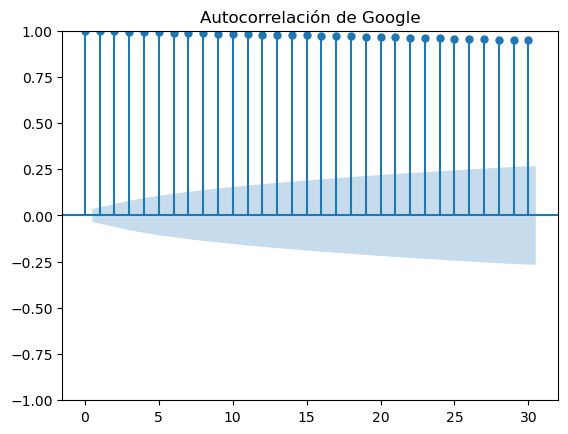

In [4]:
plot_acf(df_google['Close'], lags=30, title='Autocorrelación de Google')
plt.show()

## **Insights**
- La mayoría de lags están cerca del 1 lo que quiere decir que tienen alta importancia.
- Se puede ver además una tendencia a la baja, lo que nos indica que para la predicción, cada lag disminuye su fuerza (se incrementa el área sombrada).

___
# **Función Parcial de Autocorrelación**

- Esta función genera la correlación parcial entre los valores de una serie de tiempo y sus lags anteriores. 
- La correlación parcial es un cálculo de correlación que toma en cuenta las observaciones de la serie de tiempo separadas por sus lags, luego de ajustar por la presencia de otros términos con lags más pequeños (lo que la diferencia de ACF).
- También nos indica cuál es la importancia de los lags en la predicción.

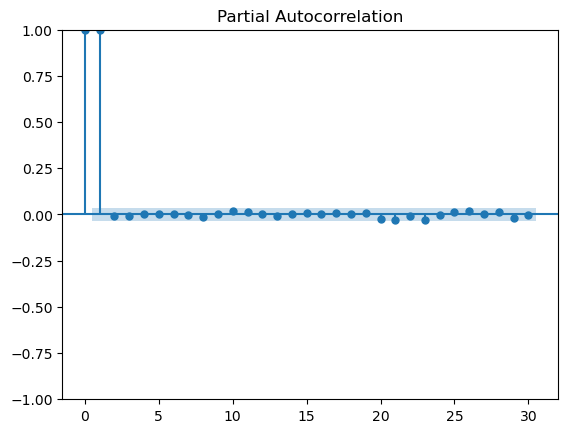

In [5]:
plot_pacf(df_google['Close'], lags=30)
plt.show()

## **Insights**
- Se como el t0 y el t1 tienen una alta correlación parcial (PACF), mientras que los demás periodos no tanto.

___
# **White Noise**
- Es una generación de información aleatoria con intensidades similares en cada frecuencia.
- Es una secuencia de variables aleatorias, no relacionadas, con una media constante (estacionarias) y varianza limitada.
- Además tiene cero correlación en sus lags (ACF).

Text(0.5, 1.0, 'White Noise')

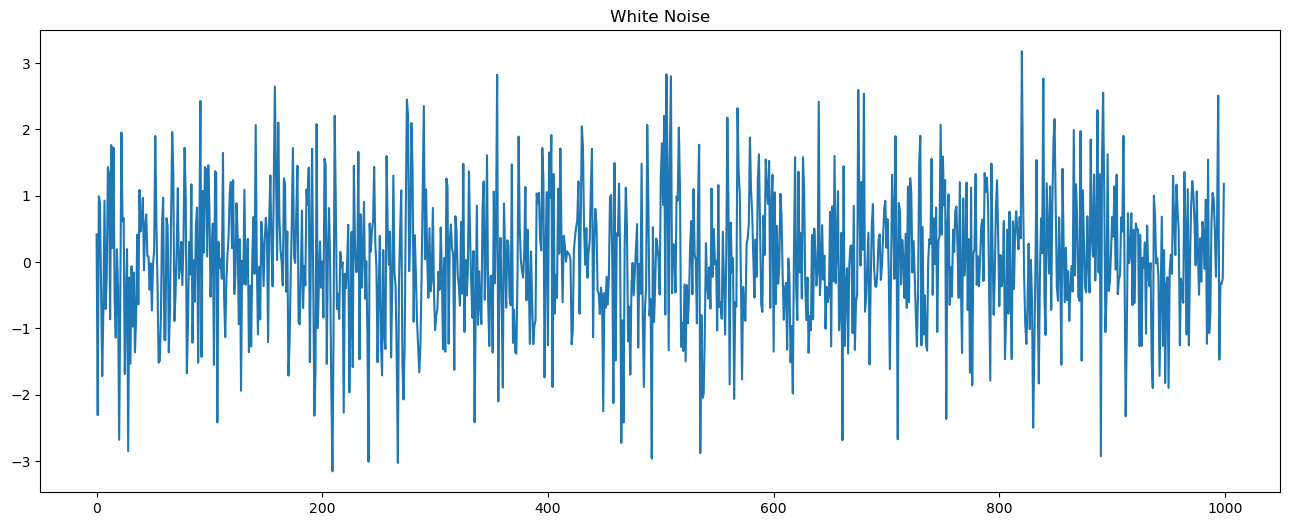

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
plt.plot(white_noise)
plt.title('White Noise')

- Visualización de autocorrelación de ruido blanco.
- Según las definiciones anteriore, debería ser cero, que es lo que se puede apreciar en el gráfico.

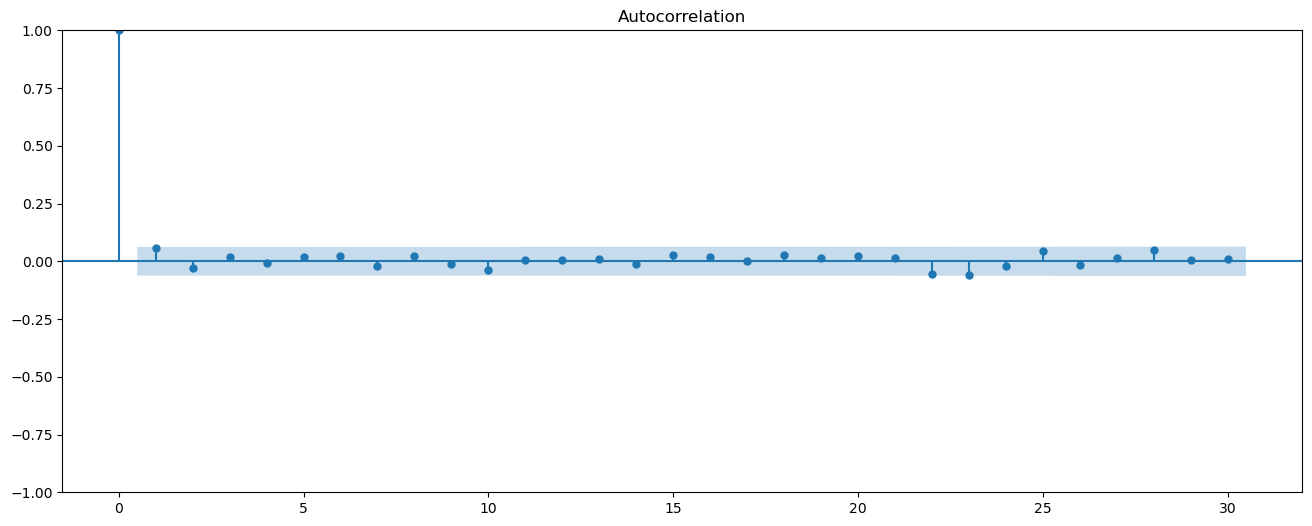

In [7]:
plot_acf(white_noise, lags=30)
plt.show()

___
# **Serie Geometric Brownian Motion**

- Serie aleatoria utilizada para predecir precios de stocks y movimientos tipo random walk.

In [8]:
from scipy.stats import norm
import pandas as pd

In [9]:
# Parámetros del proceso
delta = 0.25
dt = 0.1

# Punto inicio
x = 0.0
xini = 0

# Número de iteraciones
n = 10

**Genera los distintos puntos de la serie**

In [10]:
for k in range(n):
    x = x + norm.rvs(scale=delta**2*dt)
    print(f'Iteración {k}, valor {x}')

Iteración 0, valor 2.7167111361401792e-05
Iteración 1, valor 0.006756419632269175
Iteración 2, valor 0.012369410330220886
Iteración 3, valor 0.005940095625629076
Iteración 4, valor -0.0009711183125362902
Iteración 5, valor -0.009541500494154071
Iteración 6, valor -0.008197742077800586
Iteración 7, valor -0.006733437799912815
Iteración 8, valor -0.005173161345671372
Iteración 9, valor -0.0019092583264302587


In [21]:
# Número de trayectorias
ntra = 10

# Número de iteraciones
n = 20

# Lista temporal para acumular todo
dfres_list = []


**Genera los puntos iniciales**

In [22]:
for i in range(ntra+1):
    df2 = {'traj': i, 'nsample': 0, 'sample': xini}
    dfres_list.append(df2)

**Generar las trayectorias en un DataFrame**

In [23]:
for i in range(ntra+1):
    x = xini  # inicializa en cada trayectoria
    for k in range(1, n+1):
        x = x + norm.rvs(scale=delta**2 * dt)
        df2 = {'traj': i, 'nsample': k, 'sample': x}
        dfres_list.append(df2)

**Convertimos todo a un DataFrame**

In [24]:
dfres = pd.DataFrame(dfres_list)

print(dfres.head(15))

    traj  nsample    sample
0      0        0  0.000000
1      1        0  0.000000
2      2        0  0.000000
3      3        0  0.000000
4      4        0  0.000000
5      5        0  0.000000
6      6        0  0.000000
7      7        0  0.000000
8      8        0  0.000000
9      9        0  0.000000
10    10        0  0.000000
11     0        1  0.008394
12     0        2  0.007725
13     0        3  0.011719
14     0        4  0.012186


**Plot de las muestras**

<Axes: xlabel='nsample', ylabel='sample'>

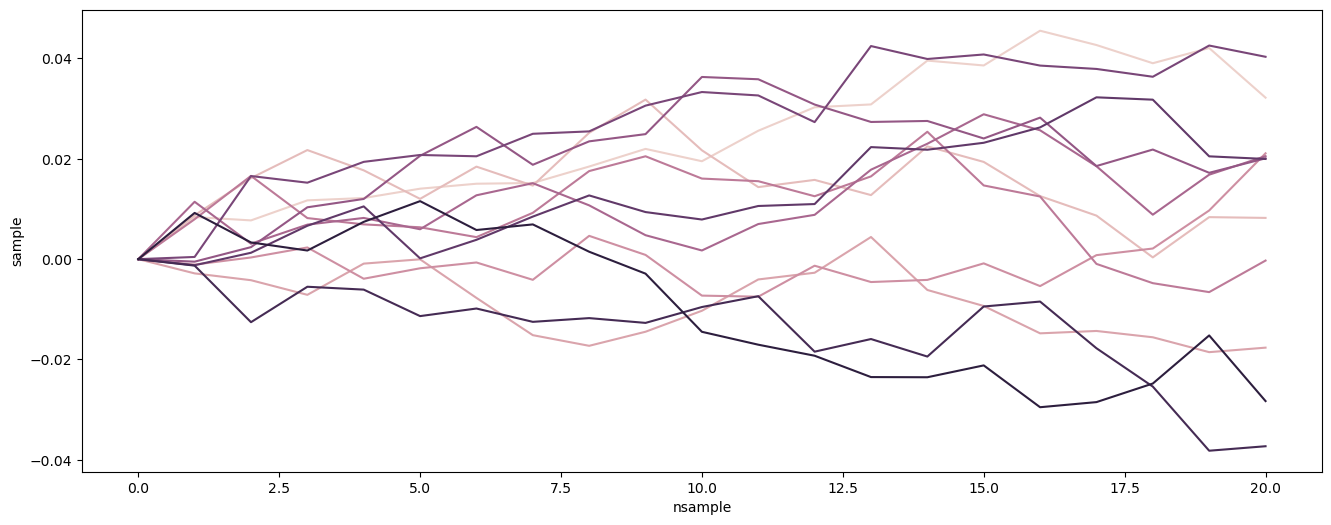

In [25]:
import seaborn as sns
sns.lineplot(data=dfres, x='nsample', y='sample', hue='traj', legend=None)

**Se pueden obtener las trayectorias**

In [26]:
pd.pivot_table(dfres, index='nsample', columns='traj', values='sample')

traj,0,1,2,3,4,5,6,7,8,9,10
nsample,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.008394,0.008751,-0.002836,-0.001085,0.007959,0.011436,-0.000499,0.000440,-0.001215,-0.001289,0.009216
2,0.007725,0.016158,-0.004194,0.000337,0.016600,0.003080,0.002395,0.016569,0.001275,-0.012562,0.003332
3,0.011719,0.021746,-0.007111,0.002331,0.008188,0.006879,0.010338,0.015243,0.006654,-0.005500,0.001722
4,0.012186,0.017705,-0.000889,-0.003902,0.006931,0.008216,0.012001,0.019395,0.010519,-0.006071,0.007438
5,0.014047,0.012018,-0.000031,-0.001818,0.006354,0.005959,0.020603,0.020767,0.000158,-0.011351,0.011566
6,0.015035,0.018444,-0.007723,-0.000662,0.004390,0.012730,0.026369,0.020505,0.003857,-0.009839,0.005809
7,0.015182,0.014665,-0.015149,-0.004118,0.009237,0.015144,0.018813,0.024990,0.008483,-0.012495,0.006927
8,0.018466,0.025189,-0.017273,0.004645,0.017557,0.010724,0.023482,0.025469,0.012703,-0.011752,0.001479


**Se puede obtener las medias de las trayectorias**

In [31]:
pd.pivot_table(dfres, columns=['nsample'], aggfunc='mean')

nsample,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
sample,0.0,0.00357,0.00461,0.006564,0.007593,0.007116,0.008083,0.007425,0.010063,0.010433,...,0.009603,0.008625,0.011867,0.013317,0.013531,0.011929,0.008901,0.00635,0.007163,0.007178
traj,5.0,5.00000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000


_____
# **Serie de Reversión a la Media**

- Conocido como el Modelo Vasicek.
- Muy utilizada para predecir tasas de Bancos Centrales, niveles de actividad económicos.

In [32]:
def mod_vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):
    np.random.seed(seed)
    dt = T/float(N)
    rates = [r0]
    for i in range(N):
        dr = K*(theta - rates[-1])*dt + sigma*np.random.normal()
        rates.append(rates[-1] +dr)
    return range(N+1), rates


**Parámetros para la serie de tiempo**

In [34]:
r0= 0.1875
K = 0.2
theta = 0.04
sigma = 0.012
T = 10
seed = np.random.randint(100, 900)
N = 1000

**Llama a la función Vasicek**

In [35]:
x, y = mod_vasicek(r0, K, theta, sigma, T, N, seed)